In [1]:
import pandas as pd
import sys
import os
import glob
from collections import defaultdict, OrderedDict
import pysam
from matplotlib import pyplot as plt
import math
# from IPython.display import display

%matplotlib inline

In [2]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()

# Unmapped reads

## Make dictionary of references

In [4]:
directory = '/scratch/groups/dpwall/personal/chloehe/unmapped_reads/bam/fam3'

# get reference dictionary for chromosomal alignments (initial alignments)
samfile = pysam.AlignmentFile(os.path.join(directory, '03C16794.final.cram')) # can use any .cram file here

reference_dict = OrderedDict()
for reference, length in zip(samfile.references, samfile.lengths):
    reference_dict[reference] = length

samfile.close()

index = []
for i in range(22):
    index.append(f'chr{i+1}')
index.extend(['chrX', 'chrY'])

window = 10000000

label_dict = OrderedDict()
for key in index:
    value = reference_dict[key]
    quotient = math.floor(value / window)
    for i in range(quotient+1):
        replacement_key = key + ':' + str(i*window + 1) + '-' + str(min(value, (i+1)*window))
        label_dict[replacement_key] = min(window, value-(i*window+1))

## Process final alignment table

Processing alignment tables for the whole family at once is memory-intensive and keeps crashing Jupyter notebook, so instead alignment tables are processed individually.

In [5]:
def plot_unmapped_reads(folder, ylim, window = 10000000):
    
    # read final_alignment_table.csv into memory
    dtype = {'R1_ref': object, 'R1_start': object, 'R1_MAPQ': 'float64',
             'R2_ref': object, 'R2_start': object, 'R2_MAPQ': 'float64',
             'is_proper_pair': bool}
    file = glob.glob(os.path.join(folder, '*alignment_table.csv'))[0]
    table = pd.read_csv(file, dtype=dtype, index_col=0)

    # filter for reads that contain chromosomal and unmapped alignments in order to make the next
    # counting step more efficient
    table_chr = table[table['R1_ref'].str.startswith('chr') | table['R2_ref'].str.startswith('chr')]
    table_chr = table_chr[(table_chr['R1_ref'] == 'unmapped') | (table_chr['R2_ref'] == 'unmapped')]

    # iterate through table by row and count unmapped reads
    counter = defaultdict(int)
    counter.clear()
    for row in table.itertuples():
        if row.R2_ref in index and row.R1_ref == 'unmapped':
            quotient = math.floor(int(row.R2_start)/window)
            key = row.R2_ref + ':' + str(quotient*window+1) + '-' + str(min((quotient+1)*window, reference_dict[row.R2_ref]))
            counter[key] += 1
        elif row.R1_ref in index and row.R2_ref == 'unmapped':
            quotient = math.floor(int(row.R1_start)/window)
            key = row.R1_ref + ':' + str(quotient*window+1) + '-' + str(min((quotient+1)*window, reference_dict[row.R1_ref]))
            counter[key] += 1

    # normalize counts
    normalized_counter = defaultdict(int)
    normalized_counter.clear()
    for key, value in counter.items():
        normalized_counter[key] = counter[key] / label_dict[key]

    # plot
    print(os.path.basename(folder))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    y = [normalized_counter[i] for i in list(label_dict)]
    plt.plot(y)
    plt.ylim(ylim)
    every_nth = 10
    plt.xticks(range(len(label_dict)), list(label_dict), size='medium', rotation='vertical')
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    plt.show()

## Family 1

In [13]:
directory = '/scratch/groups/dpwall/personal/chloehe/unmapped_reads/bam/fam1'
fam1_folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
fam1_folders.remove('old')

MH0143013


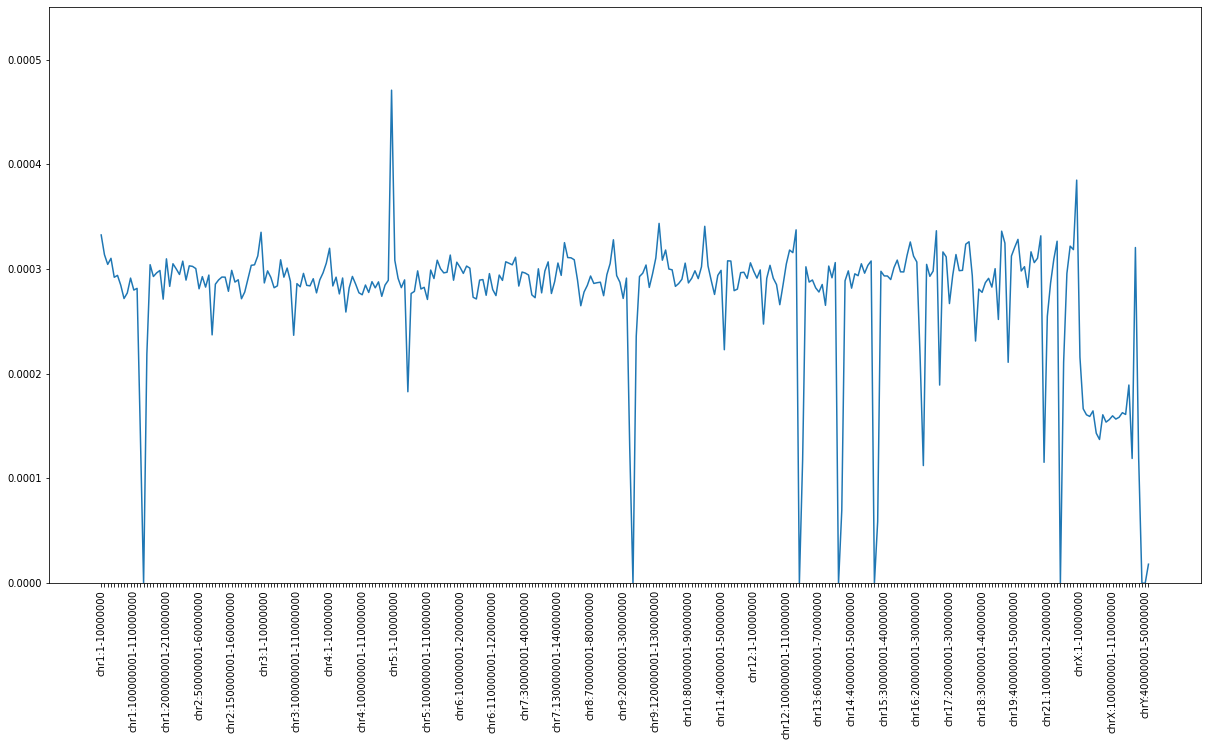

MH0143018


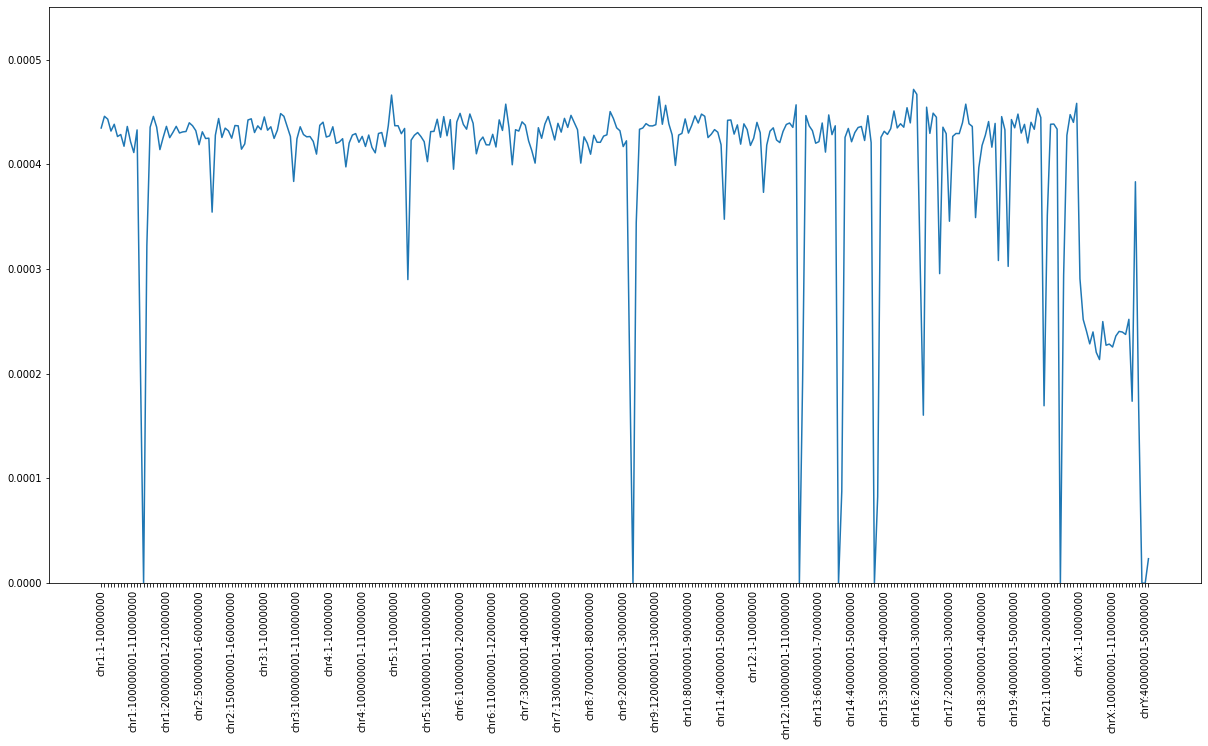

MH0143008


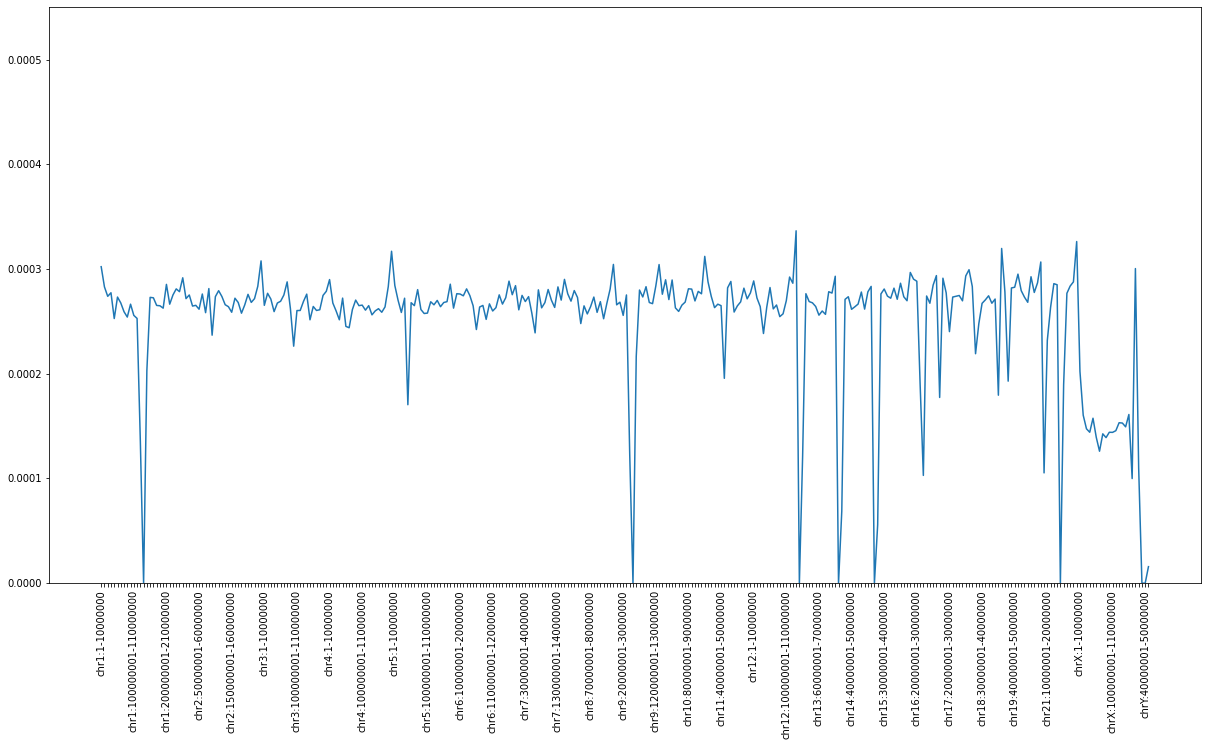

MH0143009


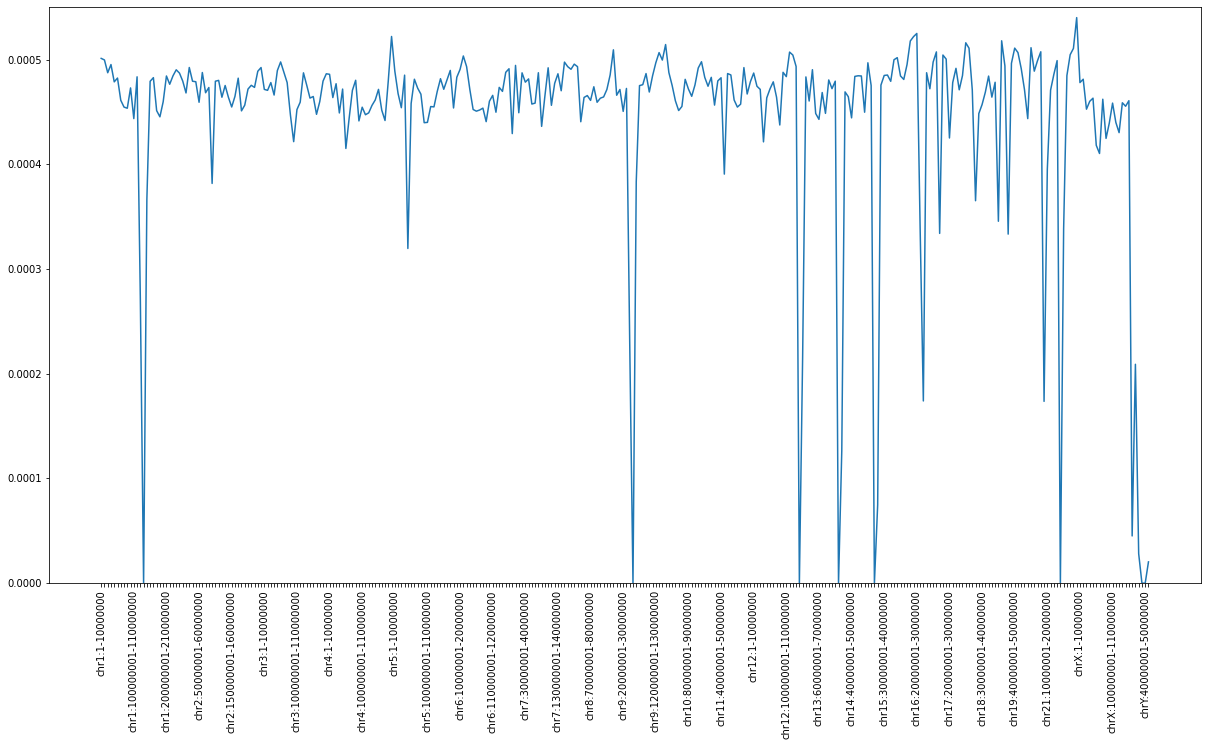

MH0143019


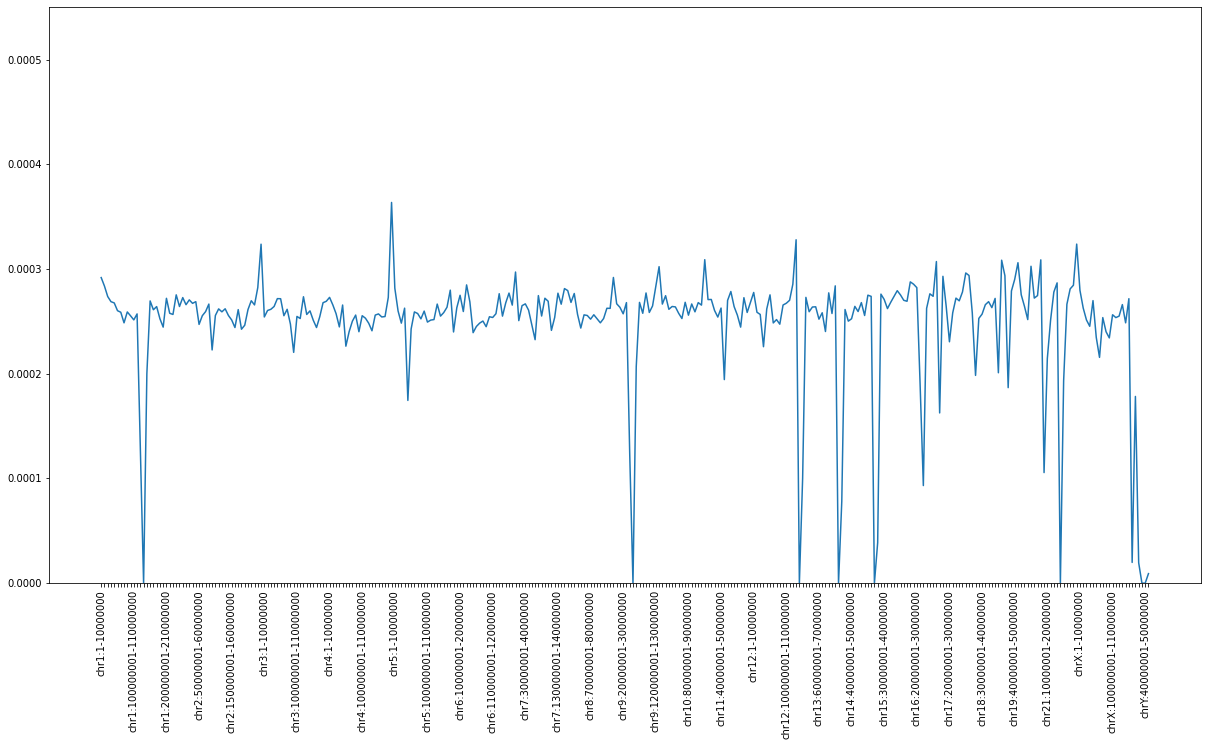

In [15]:
for folder in fam1_folders:
    plot_unmapped_reads(os.path.join(directory, folder), ylim=(0, 0.00055))

## Family 2

02C10543


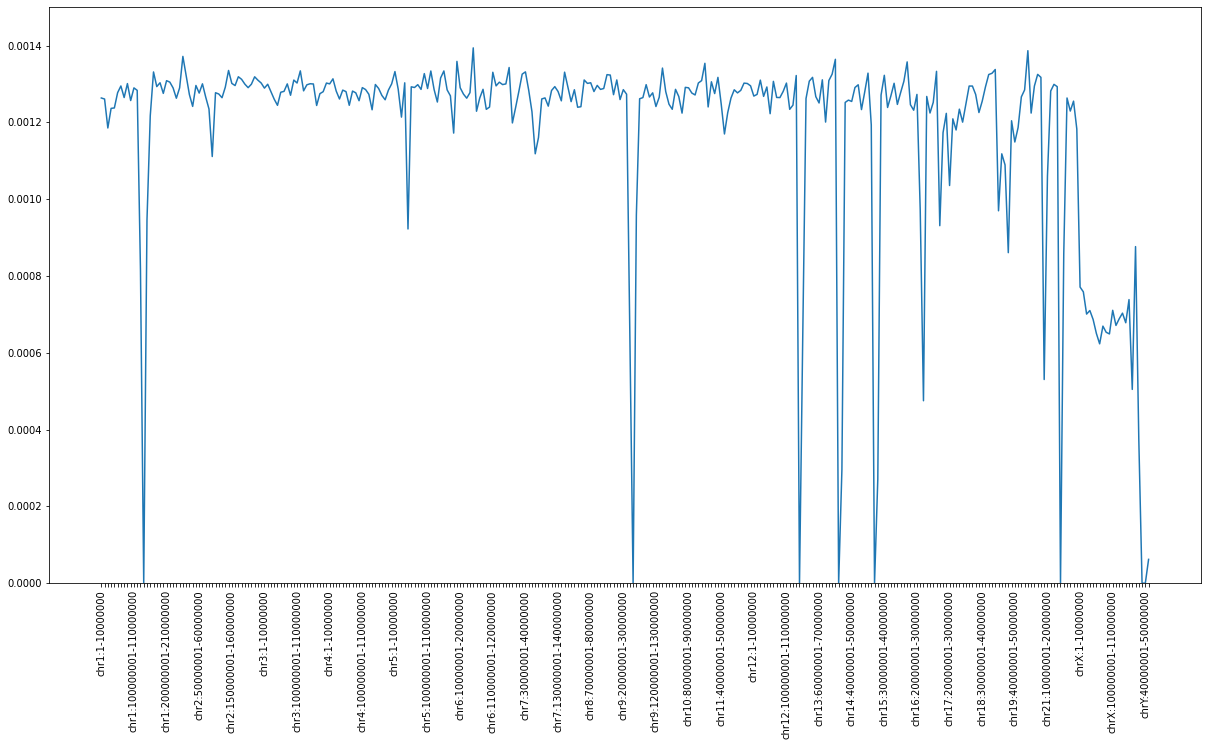

02C10540


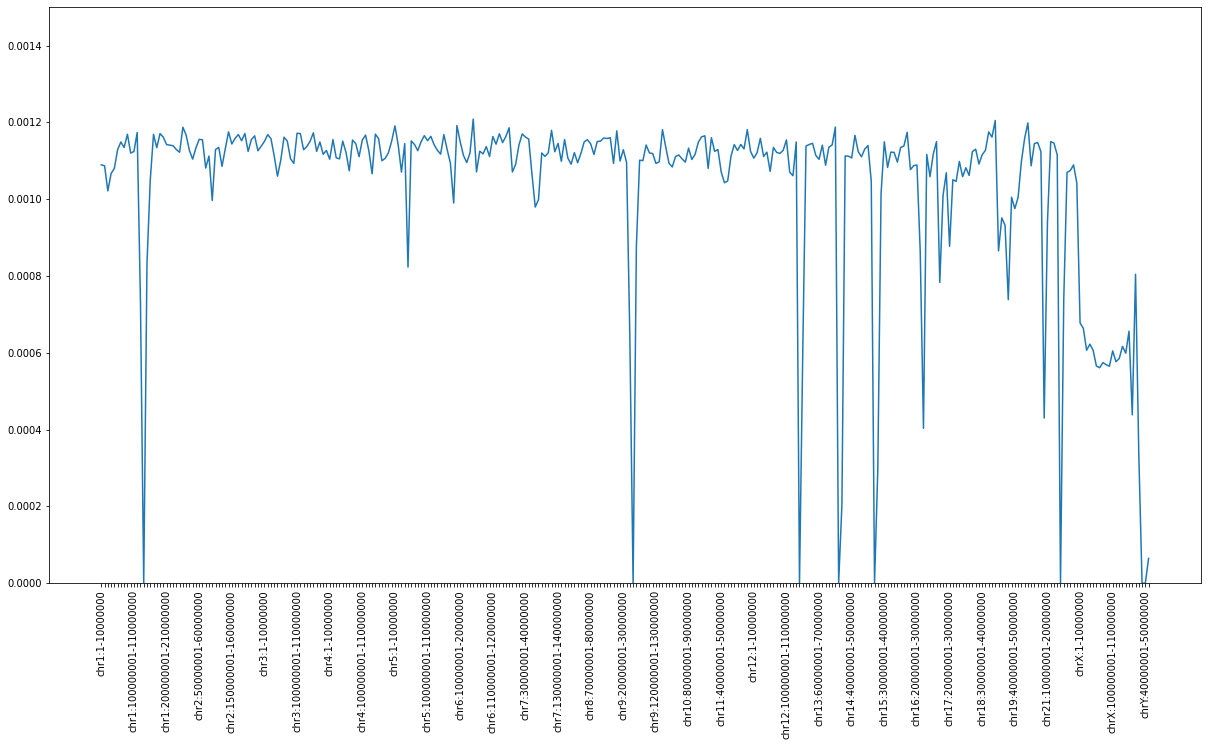

02C10541


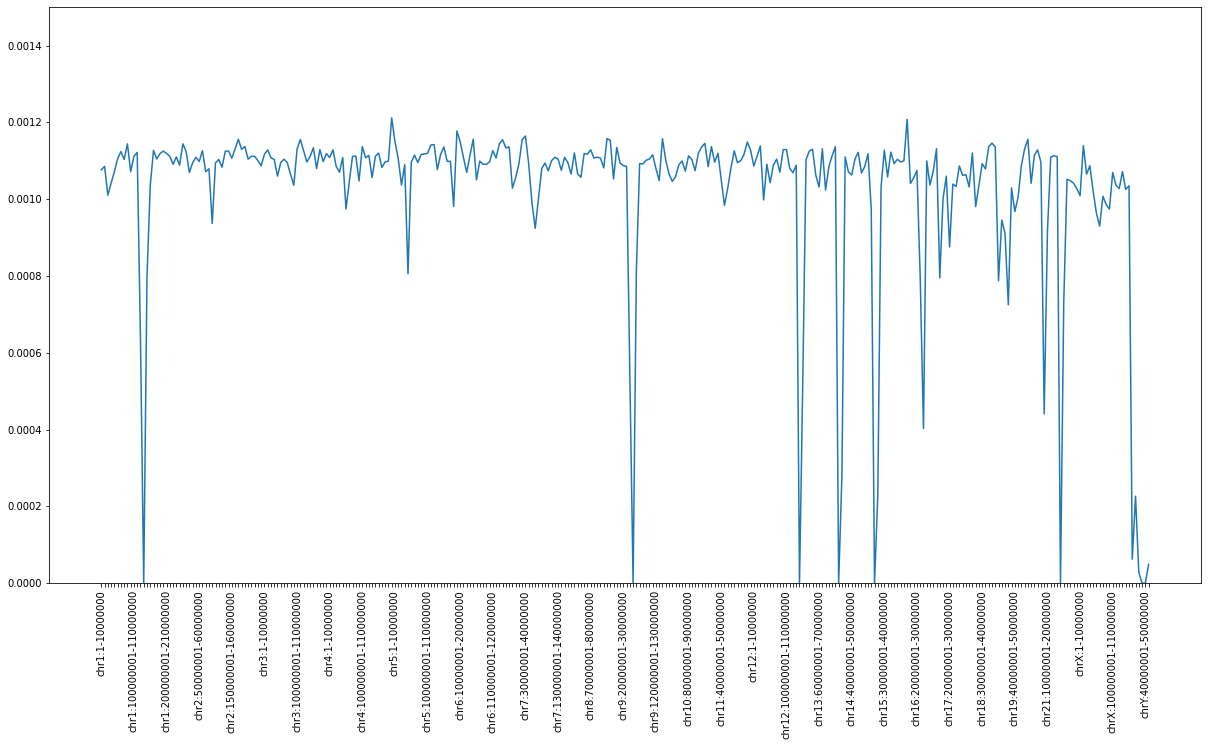

02C10542


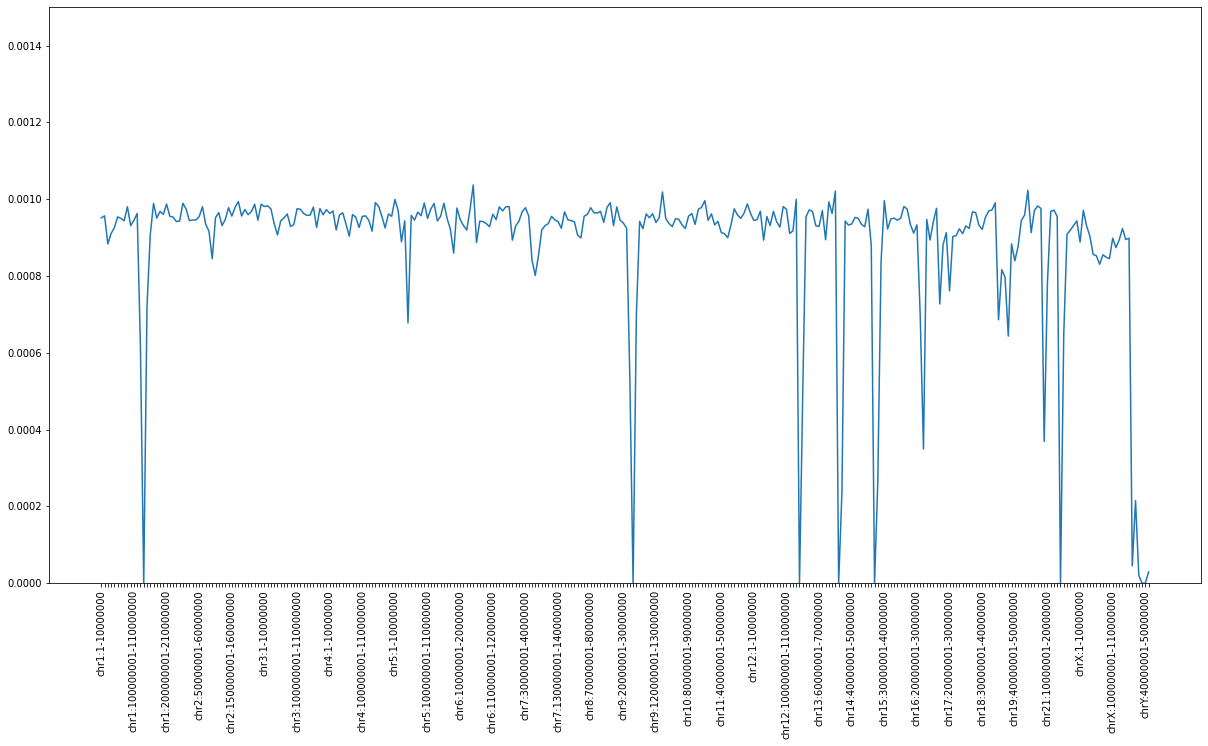

In [7]:
directory = '/scratch/groups/dpwall/personal/chloehe/unmapped_reads/bam/fam2'
fam2_folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
for folder in fam2_folders:
    plot_unmapped_reads(os.path.join(directory, folder), ylim=(0, 0.0015))

## Family 3

In [3]:
directory = '/scratch/groups/dpwall/personal/chloehe/unmapped_reads/bam/fam3'
fam3_folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

03C16794


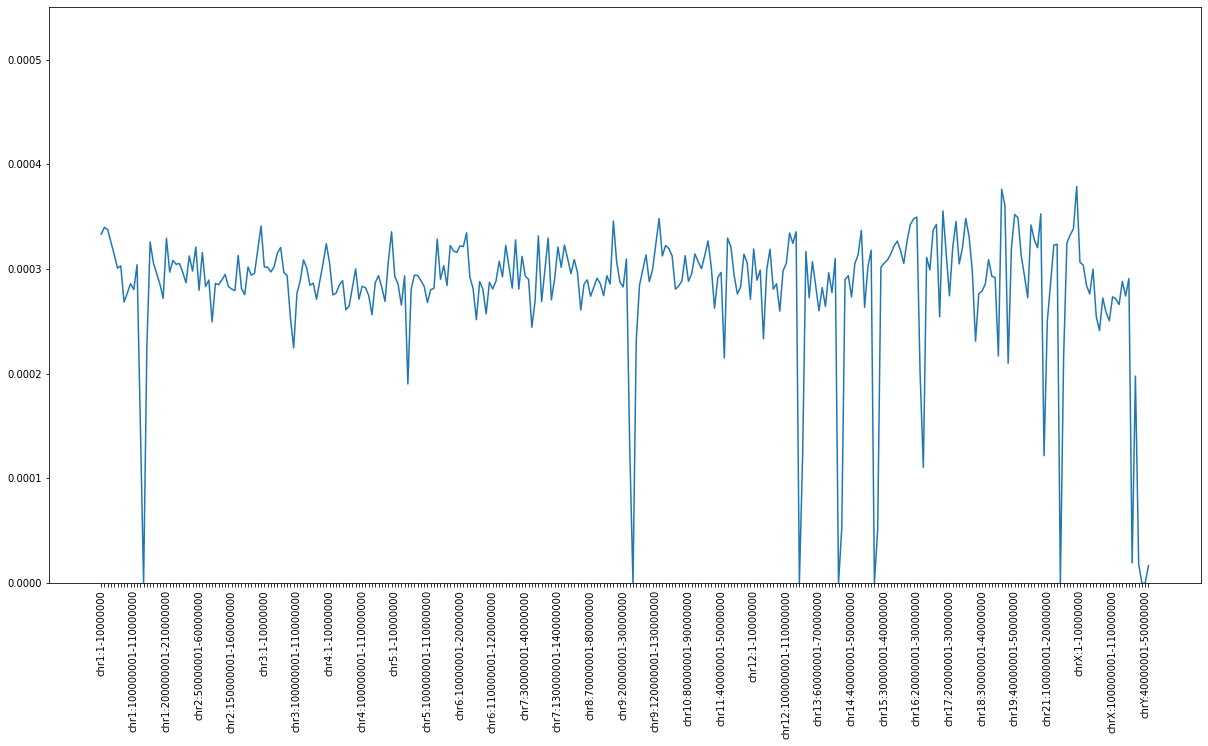

03C16797


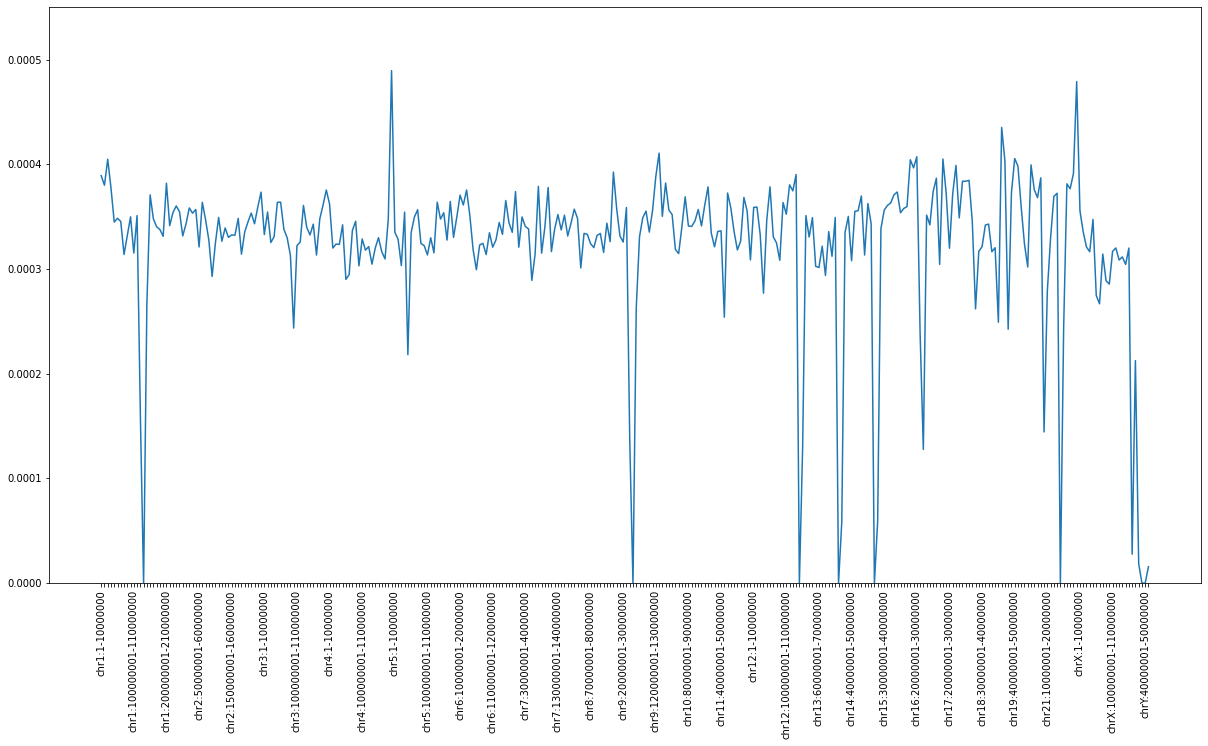

03C16798


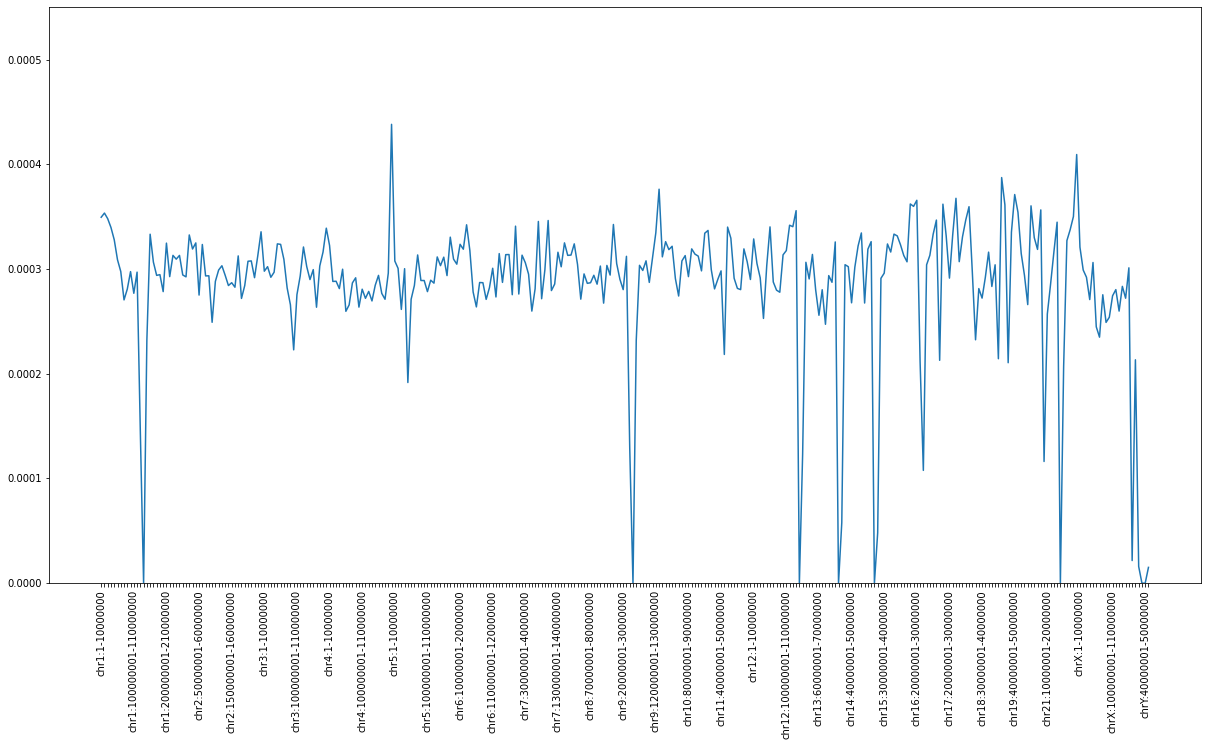

03C16796


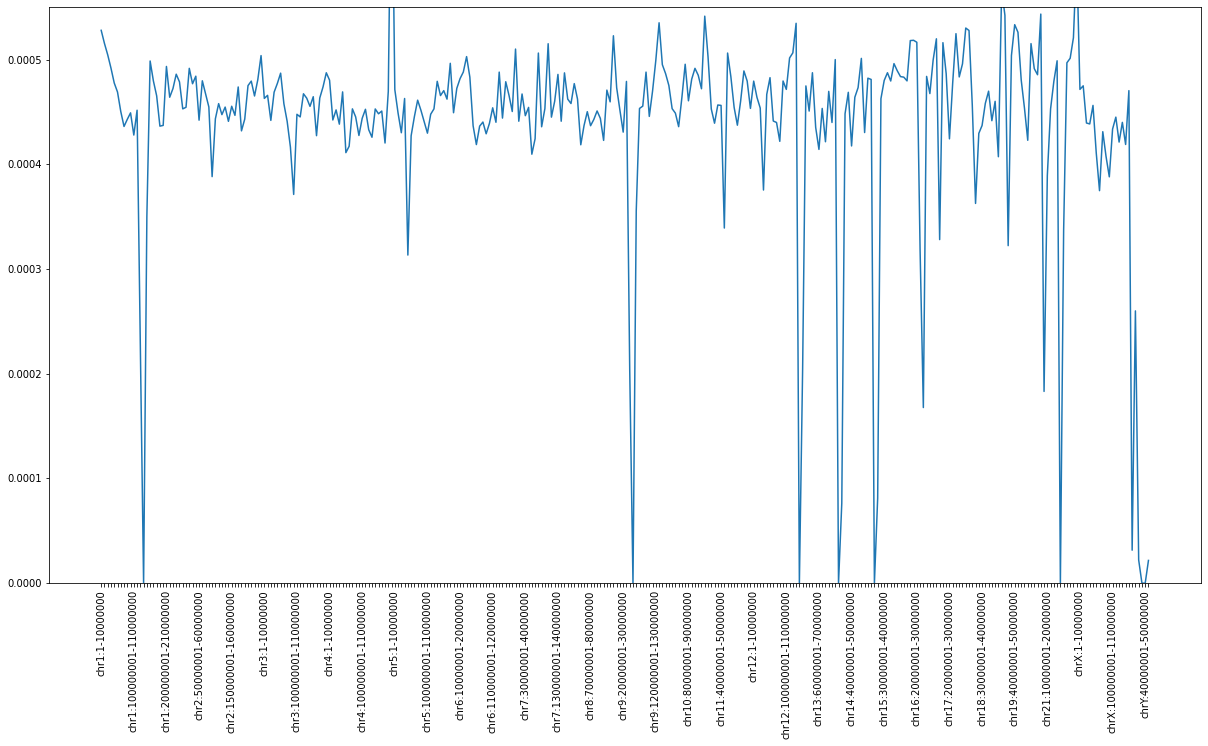

03C16795


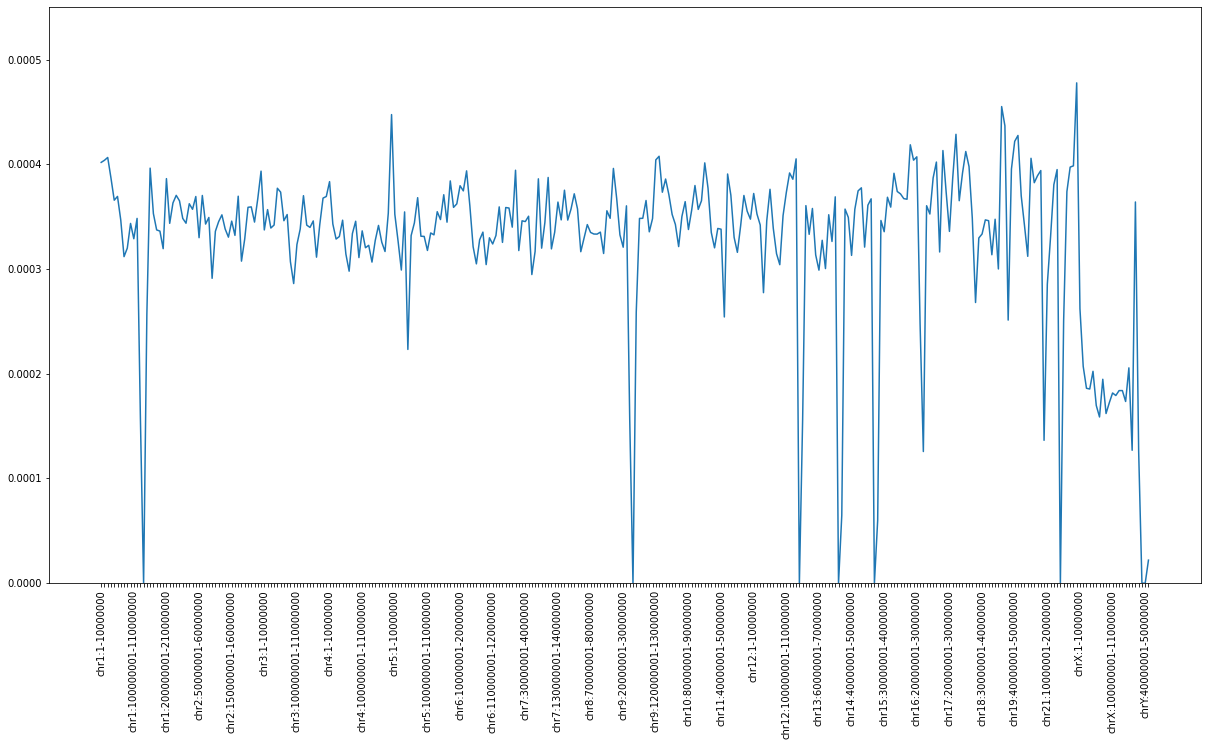

CPU times: user 4min 36s, sys: 11.5 s, total: 4min 48s
Wall time: 4min 49s


In [8]:
%%time
for folder in fam3_folders:
    plot_unmapped_reads(os.path.join(directory, folder), ylim=(0, 0.00055))


***

**Don't run the remaining code blocks in this section!!**

In [8]:
# read final_alignment_table.csv into memory
dtype = {'R1_ref': object, 'R1_start': object, 'R1_MAPQ': 'float64',
         'R2_ref': object, 'R2_start': object, 'R2_MAPQ': 'float64',
         'is_proper_pair': bool}
folder = fam3_folders[0]
file = glob.glob(os.path.join(directory, folder, '*alignment_table.csv'))[0]
table = pd.read_csv(file, dtype=dtype, index_col=0)

# filter for reads that contain chromosomal and unmapped alignments in order to make the next
# counting step more efficient
table_chr = table[table['R1_ref'].str.startswith('chr') | table['R2_ref'].str.startswith('chr')]
table_chr = table_chr[(table_chr['R1_ref'] == 'unmapped') | (table_chr['R2_ref'] == 'unmapped')]

In [11]:
table_chr

,R1_ref,R1_start,R1_MAPQ,R2_ref,R2_start,R2_MAPQ,is_proper_pair
E00134:179:H7T2JCCXX:2:1123:28506:29279,unmapped,unmapped,NaN,chr1,10129,0.0,False
E00134:179:H7T2JCCXX:4:2124:7496:39651,chr1,10141,0.0,unmapped,unmapped,NaN,False
E00134:179:H7T2JCCXX:6:1217:14448:29929,chr1,10254,0.0,unmapped,unmapped,NaN,False
E00134:179:H7T2JCCXX:7:1208:22183:24831,chr1,10355,0.0,unmapped,unmapped,NaN,False
E00134:179:H7T2JCCXX:4:1102:32394:43818,chr1,15368,0.0,unmapped,unmapped,NaN,False
...,...,...,...,...,...,...,...
E00134:179:H7T2JCCXX:5:2113:30577:28400,chrUn_JTFH01001991v1_decoy,2005,10.0,unmapped,unmapped,NaN,False
E00134:179:H7T2JCCXX:3:2210:24649:69292,unmapped,unmapped,NaN,chrUn_JTFH01001996v1_decoy,1618,12.0,False
E00134:179:H7T2JCCXX:4:2102:2492:40935,unmapped,unmapped,NaN,chrUn_JTFH01001996v1_decoy,1752,46.0,False
E00134:179:H7T2JCCXX:3:2118:32109:34711,chrUn_JTFH01001997v1_decoy,1900,0.0,unmapped,unmapped,NaN,False


In [15]:
# define a reasonable window size
# for reference, chromosome 1 contains 249 million bp, i.e. 25 10-million-bp windows
window = 10000000

counter = defaultdict(int)
counter.clear()
for _, row in table.iterrows():
    if row['R2_ref'] in index and row['R1_ref'] == 'unmapped':
        quotient = math.floor(int(row['R2_start'])/window)
        key = row['R2_ref'] + ':' + str(quotient*window+1) + '-' + str(min((quotient+1)*window, reference_dict[row['R2_ref']]))
        counter[key] += 1
    elif row['R1_ref'] in index and row['R2_ref'] == 'unmapped':
        quotient = math.floor(int(row['R1_start'])/window)
        key = row['R1_ref'] + ':' + str(quotient*window+1) + '-' + str(min((quotient+1)*window, reference_dict[row['R1_ref']]))
        counter[key] += 1

In [17]:
normalized_counter = defaultdict(int)
normalized_counter.clear()
for key, value in counter.items():
    normalized_counter[key] = counter[key] / label_dict[key]

In [25]:
normalized_counter

defaultdict(int,
            {'chr10:1-10000000': 0.0003124,
             'chr10:100000001-110000000': 0.0003143,
             'chr10:10000001-20000000': 0.0003225,
             'chr10:110000001-120000000': 0.0003069,
             'chr10:120000001-130000000': 0.0003002,
             'chr10:130000001-133797422': 0.0003128439011634475,
             'chr10:20000001-30000000': 0.0003195,
             'chr10:30000001-40000000': 0.0003125,
             'chr10:40000001-50000000': 0.0002807,
             'chr10:50000001-60000000': 0.0002837,
             'chr10:60000001-70000000': 0.0002887,
             'chr10:70000001-80000000': 0.0003127,
             'chr10:80000001-90000000': 0.0002882,
             'chr10:90000001-100000000': 0.0002956,
             'chr11:1-10000000': 0.0003268,
             'chr11:100000001-110000000': 0.000283,
             'chr11:10000001-20000000': 0.0003017,
             'chr11:110000001-120000000': 0.0003141,
             'chr11:120000001-130000000': 0.000306,
   

03C16794


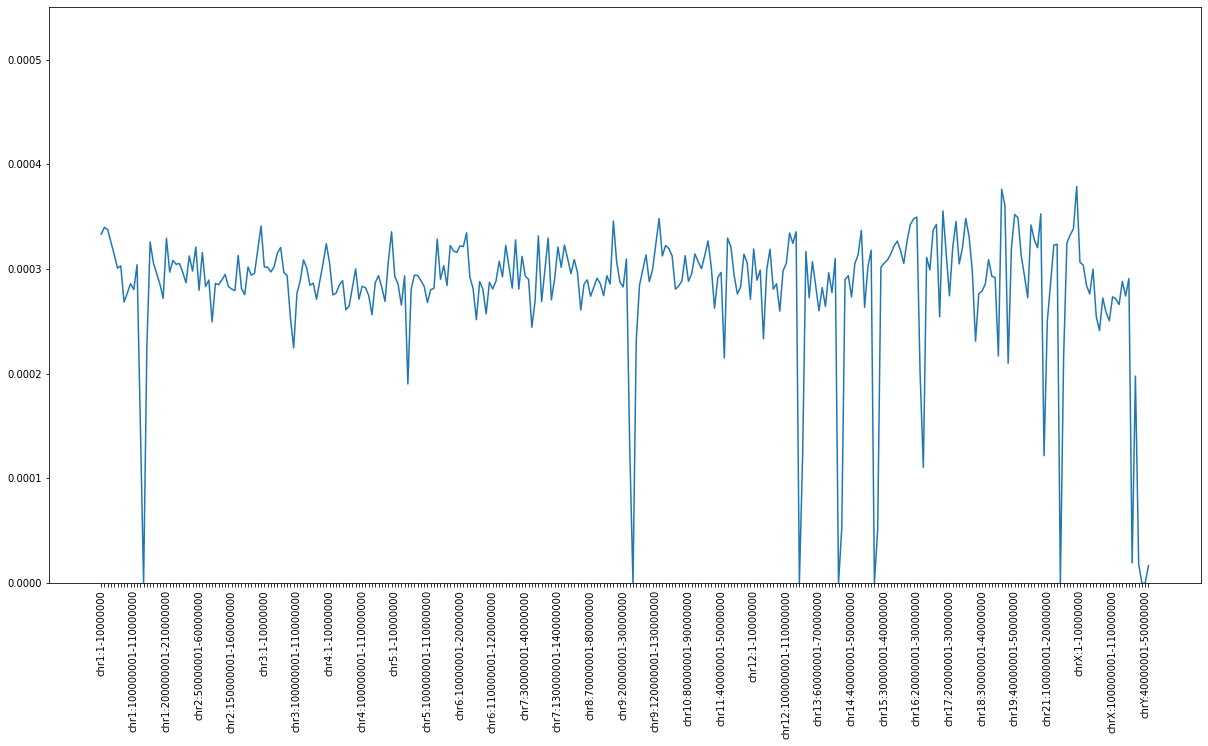

In [23]:
print(folder)
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
y = [normalized_counter[i] for i in list(label_dict)]
plt.plot(y)
plt.ylim(0, 0.00055)
every_nth = 10
plt.xticks(range(len(label_dict)), list(label_dict), size='medium', rotation='vertical')
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)


***

**Don't run the remaining code blocks in this section!!**

In [4]:
# read final_alignment_table.csv into memory
fam3_alignment_tables = []
dtype = {'R1_ref': object, 'R1_start': object, 'R1_MAPQ': 'float64',
         'R2_ref': object, 'R2_start': object, 'R2_MAPQ': 'float64',
         'is_proper_pair': bool}
for folder in fam3_folders:
    file = glob.glob(os.path.join(directory, folder, '*alignment_table.csv'))[0]
    fam3_alignment_tables.append(pd.read_csv(file, dtype=dtype, index_col=0))

In [4]:
%%time
# count unmapped reads for each file
unmapped_dict = []

for index, table in enumerate(fam3_alignment_tables):
    print(f'{index}..')
    counter = defaultdict(int)
    counter.clear()
    for _, row in table.iterrows():
        if row['R1_ref'] == 'unmapped' and not row['R2_ref'] == 'unmapped':
            counter[row['R2_ref']] += 1
        elif row['R2_ref'] == 'unmapped' and not row['R1_ref'] == 'unmapped':
            counter[row['R1_ref']] += 1
    unmapped_dict.append(counter)

0..
1..
2..
3..
4..
CPU times: user 2h 6min 51s, sys: 20.4 s, total: 2h 7min 12s
Wall time: 2h 7min 13s


In [6]:
print(len(unmapped_dict[1]))

922


In [7]:
unmapped_dict

[defaultdict(int, {'R1_ref': 863789, 'R2_ref': 13727}),
 defaultdict(int, {'R1_ref': 992994, 'R2_ref': 12951}),
 defaultdict(int, {'R1_ref': 875472, 'R2_ref': 14420}),
 defaultdict(int, {'R1_ref': 1346733, 'R2_ref': 12176}),
 defaultdict(int, {'R1_ref': 1000717, 'R2_ref': 13820})]

In [5]:
# build reference dictionary from original alignments
samfile = pysam.AlignmentFile(os.path.join(directory, '03C16794.final.cram'))
print(len(samfile.references))
print(len(samfile.lengths))

reference_dict = {}
for reference, length in zip(samfile.references, samfile.lengths):
    reference_dict[reference] = length

samfile.close()

3366
3366


In [16]:
# # add reference reads in realignment to dictionary 
# # (unnecessary if we're only interested in chromosomal unmapped reads)
# samfile = pysam.AlignmentFile(os.path.join(directory, '03C16794/03C16794.final.single.aln_all.bam'))
# print(len(samfile.references))
# print(len(samfile.lengths))

# for reference, length in zip(samfile.references, samfile.lengths):
#     reference_dict[reference] = length
    
# samfile.close()

190332
190332


In [18]:
# normalize counts
unmapped_dict_normalized = []
for dictionary in unmapped_dict:
    normalized_counter = defaultdict(int)
    normalized_counter.clear()
    for key, value in dictionary.items():
        normalized_counter[key] = dictionary[key] / reference_dict[key]
    unmapped_dict_normalized.append(normalized_counter)

In [4]:
# build index list for plotting chromosomal unmapped reads
index = []
for i in range(22):
    index.append(f'chr{i+1}')
index.extend(['chrX', 'chrY'])

03C16794
03C16797
03C16798
03C16796
03C16795


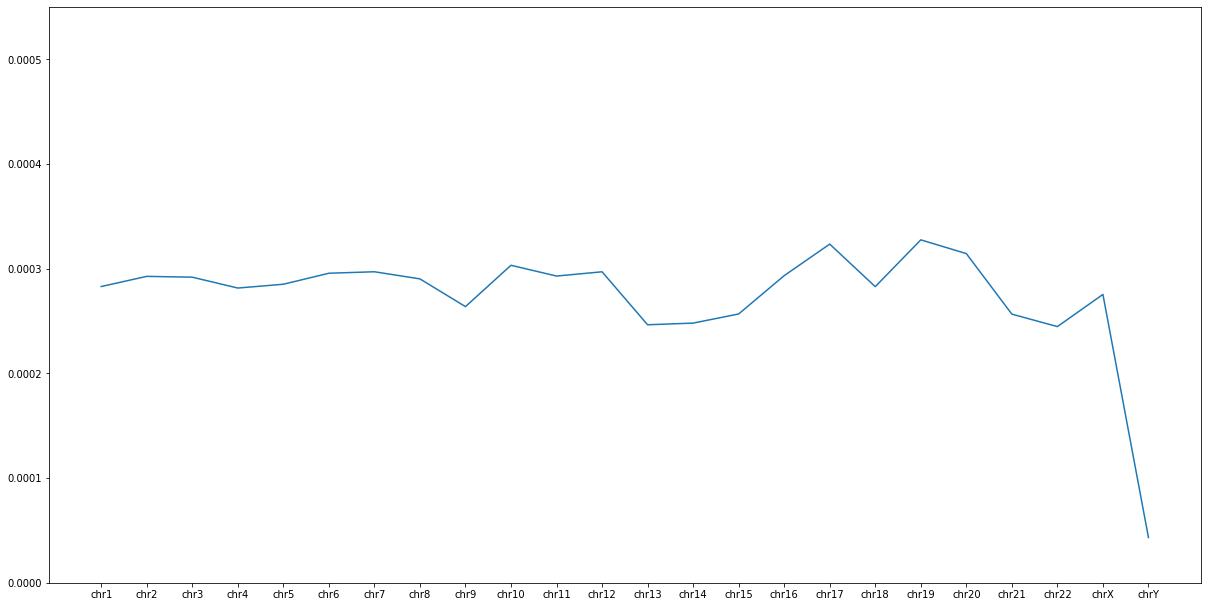

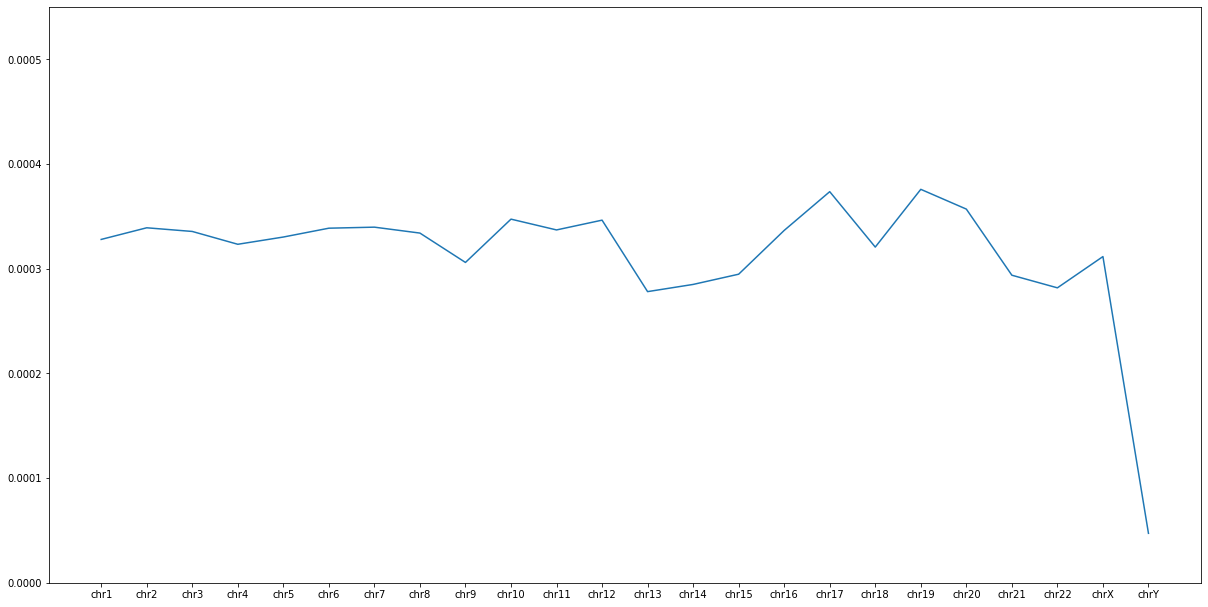

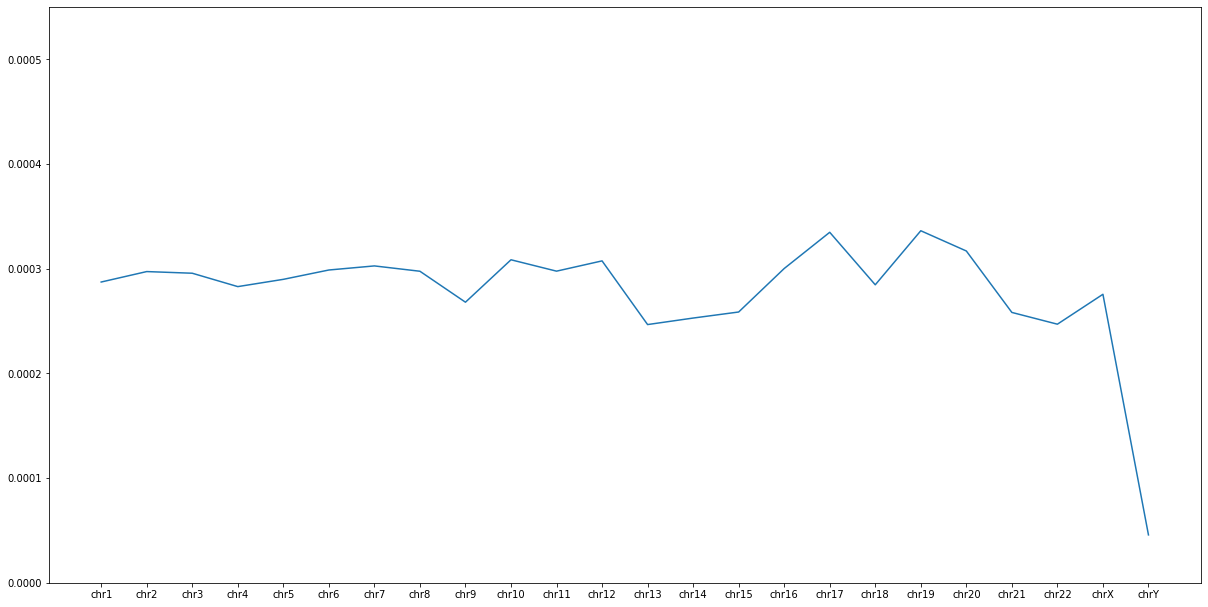

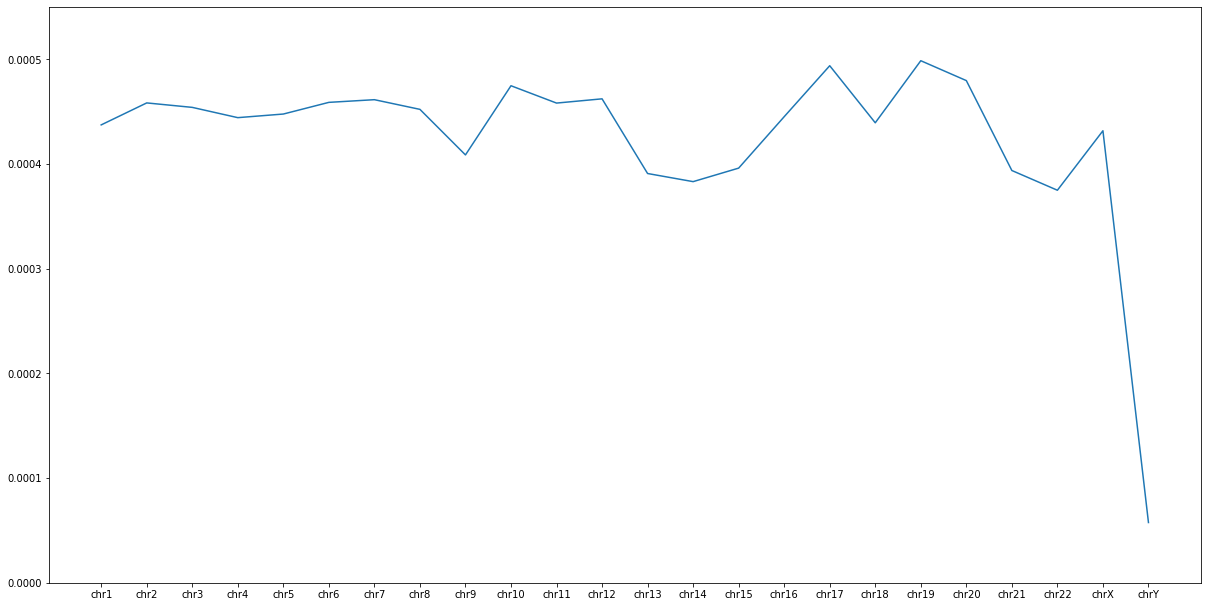

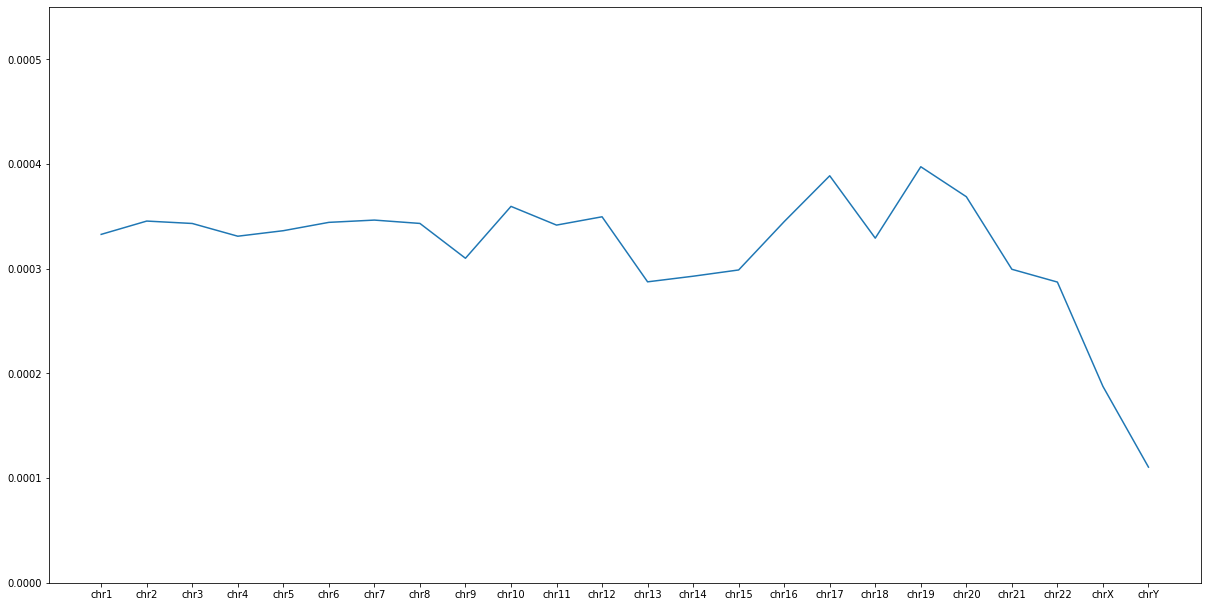

In [44]:
# plot
for file in range(len(unmapped_dict_normalized)):
    print(fam3_folders[file])
    fig= plt.figure(figsize=(20,10))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    y = [unmapped_dict_normalized[file][i] for i in index]
    plt.plot(y)
    plt.xticks(range(len(index)), index, size='medium')
    plt.ylim(0, 0.00055)

***

# Virus alignments

In [3]:
directory = '/scratch/groups/dpwall/personal/chloehe/unmapped_reads/bam/fam1'
fam1_folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
fam1_folders.remove('old')

directory = '/scratch/groups/dpwall/personal/chloehe/unmapped_reads/bam/fam3'
fam3_folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

fam1_folders

['MH0143013', 'MH0143018', 'MH0143008', 'MH0143009', 'MH0143019']

In [6]:
folder = fam1_folders[0]
# read final_alignment_table.csv into memory
dtype = {'R1_ref': object, 'R1_start': object, 'R1_MAPQ': 'float64',
         'R2_ref': object, 'R2_start': object, 'R2_MAPQ': 'float64',
         'is_proper_pair': bool}
file = glob.glob(os.path.join(directory, folder, '*alignment_table.csv'))[0]
table = pd.read_csv(file, dtype=dtype, index_col=0)

In [7]:
table[table['R1_ref'].str.startswith('MH') | table['R2_ref'].str.startswith('MH')]

,R1_ref,R1_start,R1_MAPQ,R2_ref,R2_start,R2_MAPQ,is_proper_pair
E00138:137:H7TCJCCXX:5:1204:30648:3805,MH533023.1,7,40.0,MH533023.1,4,60.0,True
E00138:137:H7TCJCCXX:7:2219:15656:23794,MH533023.1,71,60.0,MH533023.1,280,60.0,True
E00138:137:H7TCJCCXX:7:2121:5841:16322,MH533023.1,284,60.0,MH533023.1,283,55.0,True
E00138:137:H7TCJCCXX:6:1215:28344:35784,MH533023.1,381,60.0,MH533023.1,155,60.0,True
E00138:137:H7TCJCCXX:6:2212:29217:2100,MH533023.1,84,60.0,MH533023.1,386,60.0,True
...,...,...,...,...,...,...,...
E00138:137:H7TCJCCXX:7:2208:26720:27626,chrUn_JTFH01000485v1_decoy,150,60.0,MH533812.1,1481,60.0,False
E00138:137:H7TCJCCXX:4:1214:30658:28154,chrUn_JTFH01000485v1_decoy,151,60.0,MH533812.1,1401,60.0,False
E00138:137:H7TCJCCXX:8:1102:28770:3963,MH533994.1,762,60.0,chrUn_JTFH01001347v1_decoy,332,60.0,False
E00138:137:H7TCJCCXX:5:2121:14996:49233,MH533263.1,221,60.0,chrUn_JTFH01001510v1_decoy,102,60.0,False


In [10]:
table[table['R1_ref'].str.startswith('NC') | table['R2_ref'].str.startswith('NC')
      | table['R1_ref'].str.startswith('VIRL') | table['R2_ref'].str.startswith('VIRL')]

,R1_ref,R1_start,R1_MAPQ,R2_ref,R2_start,R2_MAPQ,is_proper_pair
E00138:137:H7TCJCCXX:4:2104:4836:39898,VIRL|gi|77020112|ref|NC_006356.2|,29058,14.0,chr12,66057592,0.0,False
E00138:137:H7TCJCCXX:8:1111:7313:60431,chr6,160100719,40.0,VIRL|gi|77020112|ref|NC_006356.2|,30760,10.0,False
E00138:137:H7TCJCCXX:5:1221:31338:42587,MH533702.1,6316,10.0,VIRL|gi|307346999|ref|NC_014513.1|,1447,24.0,False
E00138:137:H7TCJCCXX:6:2223:30323:59605,VIRL|gi|213159161|ref|NC_011587.1|,170276,10.0,VIRL|gi|213159161|ref|NC_011587.1|,167244,10.0,True
E00138:137:H7TCJCCXX:7:1222:29836:60554,VIRL|gi|213159161|ref|NC_011587.1|,170280,12.0,VIRL|gi|213159161|ref|NC_011587.1|,167251,12.0,True
...,...,...,...,...,...,...,...
E00138:137:H7TCJCCXX:7:1213:11830:46279,VIRL|gi|9626372|ref|NC_001422.1|,3076,60.0,chr18,60739783,60.0,False
E00138:137:H7TCJCCXX:7:1115:11302:50569,chr18,77318467,60.0,VIRL|gi|9626372|ref|NC_001422.1|,2885,60.0,False
E00138:137:H7TCJCCXX:5:2223:19848:27292,VIRL|gi|9626372|ref|NC_001422.1|,2544,60.0,chr19,16120309,6.0,False
E00138:137:H7TCJCCXX:8:1218:4928:37313,VIRL|gi|9626372|ref|NC_001422.1|,4911,60.0,chr20,54355257,59.0,False


In [ ]:
fam3_viral_counts = []

for folder in fam3_folders:
    # read final_alignment_table.csv into memory
    dtype = {'R1_ref': object, 'R1_start': object, 'R1_MAPQ': 'float64',
             'R2_ref': object, 'R2_start': object, 'R2_MAPQ': 'float64',
             'is_proper_pair': bool}
    file = glob.glob(os.path.join(directory, folder, '*alignment_table.csv'))[0]
    table = pd.read_csv(file, dtype=dtype, index_col=0)
    
    table_viral = table[table['R1_ref'].str.startswith('NC') | table['R2_ref'].str.startswith('NC')
                        | table['R1_ref'].str.startswith('VIRL') | table['R2_ref'].str.startswith('VIRL')]
    
    r1 = table_viral.R1_ref.value_counts().to_frame()
    r1.columns = [folder + '_R1']
    r2 = table_viral.R2_ref.value_counts().to_frame()
    r2.columns = [folder + '_R2']
    fam3_viral_counts.extend([r1, r2])

fam3_viral_counts = pd.concat(fam3_viral_counts, axis=1)
fam3_viral_filtered = fam3_viral_counts[fam3_viral_counts.ge(10).any(axis=1)]
fam3_viral_filtered['sum'] = fam3_viral_filtered.sum(1)
fam3_viral_filtered = fam3_viral_filtered.sort_values('sum', ascending=False)
fam3_viral_filtered

In [5]:
fam1_viral_counts = []

for folder in fam3_folders:
    # read final_alignment_table.csv into memory
    dtype = {'R1_ref': object, 'R1_start': object, 'R1_MAPQ': 'float64',
             'R2_ref': object, 'R2_start': object, 'R2_MAPQ': 'float64',
             'is_proper_pair': bool}
    file = glob.glob(os.path.join(directory, folder, '*alignment_table.csv'))[0]
    table = pd.read_csv(file, dtype=dtype, index_col=0)
    
    table_viral = table[table['R1_ref'].str.startswith('NC') | table['R2_ref'].str.startswith('NC')
                        | table['R1_ref'].str.startswith('VIRL') | table['R2_ref'].str.startswith('VIRL')]
    
    r1 = table_viral.R1_ref.value_counts().to_frame()
    r1.columns = [folder + '_R1']
    r2 = table_viral.R2_ref.value_counts().to_frame()
    r2.columns = [folder + '_R2']
    fam1_viral_counts.extend([r1, r2])

fam1_viral_counts = pd.concat(fam1_viral_counts, axis=1)
fam1_viral_filtered = fam1_viral_counts[fam1_viral_counts.ge(10).any(axis=1)]
fam1_viral_filtered['sum'] = fam1_viral_filtered.sum(1)
fam1_viral_filtered = fam1_viral_filtered.sort_values('sum', ascending=False)
fam1_viral_filtered

,03C16794_R1,03C16794_R2,03C16797_R1,03C16797_R2,03C16798_R1,03C16798_R2,03C16796_R1,03C16796_R2,03C16795_R1,03C16795_R2,sum
VIRL|gi|9626372|ref|NC_001422.1|,545439.0,543316.0,338096.0,337146.0,472024.0,470496.0,214212.0,213806.0,699588.0,697026.0,4531149.0
NC_048798.1,9444.0,NaN,22171.0,NaN,28537.0,1.0,15207.0,NaN,6612.0,NaN,81972.0
BACT_5005|gnl|WGS:AECW|A_sp_Oral_taxon_171_F0337-1.0_Cont345.1|gb|AECW01000319,NaN,7475.0,NaN,18408.0,NaN,23578.0,NaN,12240.0,NaN,4409.0,66110.0
unmapped,574.0,2555.0,222.0,1077.0,271.0,1660.0,125.0,515.0,820.0,3171.0,10990.0
BACT_1380|gi|300941379|ref|NZ_GG772768.1|,NaN,233.0,NaN,791.0,NaN,1299.0,NaN,1147.0,NaN,438.0,3908.0
EUKY_22|gi|258549241|ref|NC_004317.2|,1.0,100.0,NaN,462.0,NaN,343.0,NaN,213.0,NaN,61.0,1180.0
VIRL|gi|73852470|ref|NC_007346.1|,92.0,90.0,94.0,97.0,86.0,83.0,106.0,105.0,97.0,91.0,941.0
chr2,30.0,146.0,32.0,150.0,25.0,229.0,36.0,108.0,20.0,152.0,928.0
chr1,13.0,114.0,13.0,94.0,15.0,159.0,15.0,73.0,7.0,116.0,619.0
chr4,10.0,76.0,16.0,66.0,16.0,111.0,16.0,37.0,12.0,100.0,460.0
